In [107]:
%matplotlib inline 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import io
import sys
import datetime
import math
import scipy.io
import re

## Load in lidar data from matlab file

In [108]:
# load with scipy
mat = scipy.io.loadmat('SOS_lidar_data.mat')

# if interested in checking the variables in the mat file
for var_name in mat.keys():
    if not var_name.startswith("__"):  # Ignore special __header__, __version__, __globals__ entries
        print(f'{var_name}: {mat[var_name].shape}')

# flatten np array to 1D
mat['L4due'] = mat['L4due'].flatten()

# create dataframe and datetime index from start date for instrument
# clip to zero and interpolate missing values
start_date = pd.to_datetime('2022-10-14 00:00:00')
index = pd.date_range(start=start_date, periods=len(mat['L4due']), freq='H')
df = pd.DataFrame({'L4due': mat['L4due']}, index=index)
df.interpolate(method='linear', inplace=True)
df.clip(lower=0, inplace=True)

# select data to align with all sensors
df = df[(df.index >= '2022-11-01') & (df.index < '2023-06-01')]

L1: (4541, 1)
L11time: (4541, 1)
L1cd: (5812, 1)
L1cue: (4541, 1)
L1cuw: (2375, 1)
L1time: (5812, 1)
L2duw: (2100, 1)
L3ued: (4122, 1)
L3ueue: (5800, 1)
L3ueuw: (2375, 1)
L4: (5812, 1)
L44time: (5800, 1)
L4dd: (5812, 1)
L4due: (5800, 1)
L4duw: (2100, 1)
L4time: (2100, 1)
L4uwd: (5812, 1)
None: (1,)


/Users/clintonalden/miniconda3/envs/env1/lib/python3.12/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_70095/2218566962.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(mat['L4due']), freq='H')


## Load in thermistor array data

In [109]:
path = './sos_hourly_ds.nc'

ds = xr.open_dataset(path)
ds = ds.sel(time=slice('2022-11-01', '2023-05-31'))

ds_soil = ds[[var for var in ds.data_vars if 'Tsoil' in var]]
ds = ds[[var for var in ds.data_vars if 'Tsnow' in var]]

ds_soil = ds_soil['Tsoil_0_6cm_d']


In [110]:
ds = ds[[var for var in ds.data_vars if 'Tsnow' in var]]

# Calculate the difference between consecutive time steps
diff = ds.diff(dim='time')

# Create a mask where the absolute difference is less than or equal to 1
# mask = abs(diff) <= .2

mask = ds <= 2 or ds >= -12 

# Apply the mask to the Dataset
ds = ds.where(mask)

In [111]:
new_column_names = {'Tsnow_0_4m_d': 'uwTsnow0_4', 'Tsnow_0_5m_d': 'uwTsnow0_5', 'Tsnow_0_6m_d': 'uwTsnow0_6',
                    'Tsnow_0_7m_d': 'uwTsnow0_7', 'Tsnow_0_8m_d': 'uwTsnow0_8', 'Tsnow_0_9m_d': 'uwTsnow0_9',
                    'Tsnow_1_0m_d': 'uwTsnow1_0', 'Tsnow_1_1m_d': 'uwTsnow1_1', 'Tsnow_1_2m_d': 'uwTsnow1_2',
                    'Tsnow_1_3m_d': 'uwTsnow1_3', 'Tsnow_1_4m_d': 'uwTsnow1_4', 'Tsnow_1_5m_d': 'uwTsnow1_5'}

ds = ds.rename(new_column_names)


In [112]:
# Mask out where above top of snow
# very inefficient, but works
for i in ds.time:
    timestamp = pd.to_datetime(i.values)
    for j in ds.data_vars:
        number = float(re.findall(r'\d+\.\d+', j.replace('_', '.'))[0]) # extract depth from var name
        if number > df['L4due'].loc[timestamp]:
            mask = ds['time'] != i
            ds[j] = ds[j].where(mask, np.nan)



In [113]:
# Mask out soil temp where no snow
for i in ds_soil.time:
    timestamp = pd.to_datetime(i.values)
    if df['L4due'].loc[timestamp] < 0.1:
        mask = ds_soil['time'] != i
        ds_soil = ds_soil.where(mask, np.nan)

In [114]:
# initialize depth array
depths = np.arange(0.4, 1.6, 0.1)

# Create a list of names
var_names = [f'uwTsnow{int(i/10)}_{i%10}' for i in range(4, 16)]

# Create an empty list to store the arrays
arrays = []

# Loop over the desired range
for i in range(4, 16):
    # Create an array filled with the current value and append it to the list
    arrays.append(np.full(5088, i / 10.0))

# Convert the list of arrays into a 2D array
array = np.array(arrays)

# Extract the depths from the variable names
depths = [float(var.split('_')[1].replace('_', '.')) for var in var_names]

# Create a 2D array where each row corresponds to a variable and each column corresponds to a time point
data = np.array([ds[var].values for var in var_names])

# Create a 2D array for the y coordinates (depths)
depths = np.array([np.full_like(ds[var].values, depth) for depth, var in zip(depths, var_names)])/10

# Create a 2D array for the x coordinates (time points)
times = np.array([ds[var].coords['time'].values for var in var_names])


In [115]:
new_row = ds_soil.values  # Convert the Dataset variable to a numpy array

# Make sure the new row has the same number of columns as the array
assert new_row.shape[0] == data.shape[1]

In [116]:
# Assuming `array` is your 12x5088 numpy array
new_row = np.zeros(array.shape[1])  # Create a new row filled with zeros

In [117]:
new_row = times[0, :]  # Get the first row
# times = np.vstack((times, new_row))


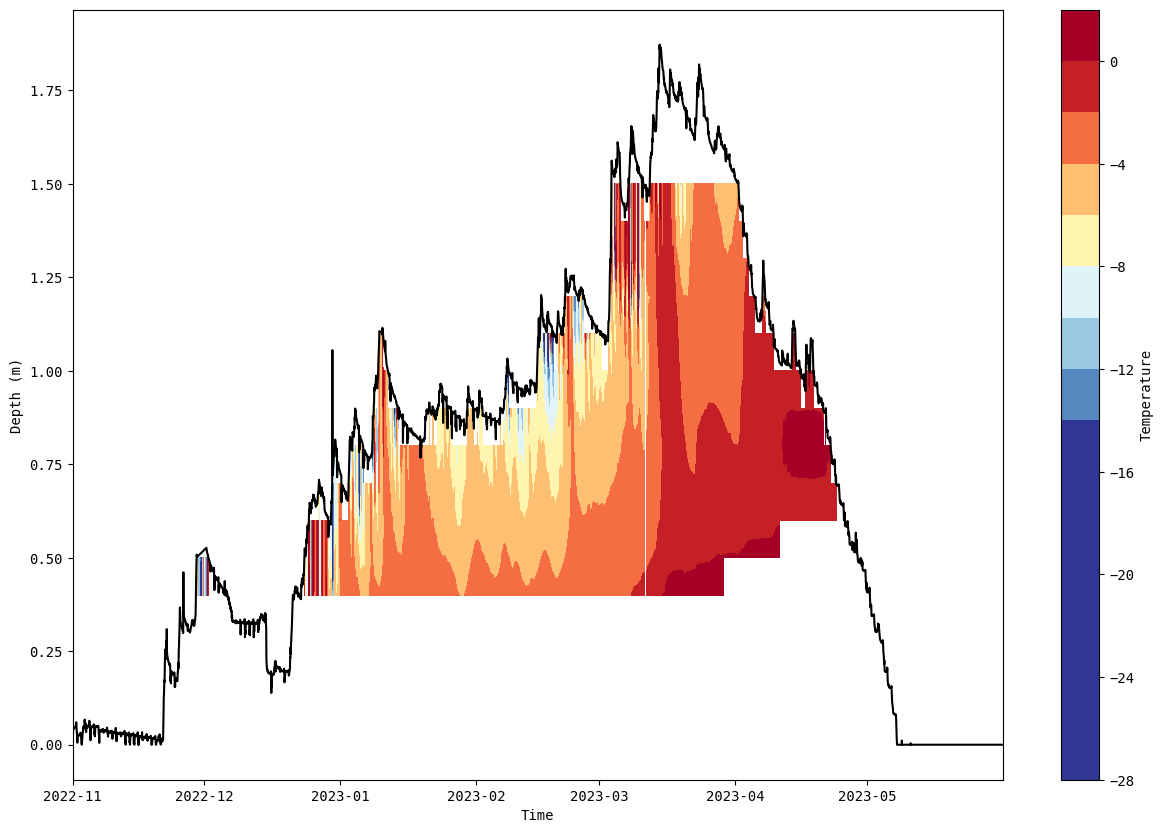

In [118]:
plt.figure(figsize=(15, 10))

# Create a filled contour plot
plt.contourf(times, array, data, vmin=-15, vmax=0, levels=15, cmap='RdYlBu_r')

# Add a colorbar
plt.colorbar(label='Temperature')

# Set the y-axis direction to reverse (so that depth increases downwards)
# plt.gca().invert_yaxis()

# Plot summa snow depth output
# plt.plot(summa_out['time'], summa_out['scalarSnowDepth'], color='black')
plt.plot(df.index, df['L4due'], color='black')

# Set the labels for the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Depth (m)')

# plt.xlim([np.datetime64('2023-02-01'), np.datetime64('2023-03-31')])

# Show the plot
plt.show()

In [119]:
# Reshape df['L4due'] to match the shape of depths
L4due = np.repeat(df['L4due'].values[None, :], depths.shape[0], axis=0)

L4due = L4due[:,:5544]

# Create a mask where the depths are less than or equal to L4due
mask = depths <= L4due

# Apply the mask to the data
data_masked = np.where(mask, data, np.nan)

In [120]:
L4due[:,:5544].shape

# Create a 2D array for the y coordinates (depths)
depths = np.array([np.full_like(ds[var].values, depth) for depth, var in zip(depths, var_names)])/10


In [121]:
times = times[0,:]
# array = array.flatten(axis=1)
da = xr.DataArray(data, coords=[('bins', array[:,0]), ('time', times)])

In [173]:
summa_out = xr.open_dataset('./template_output_z0snow05_1hr_timestep.nc')

depth = summa_out.isel(hru=0)['iLayerHeight']
# depth = depth.where(depth != -9999, np.nan)
# depth = depth.where(depth != 9999, np.nan)

temp = summa_out.isel(hru=0)['mLayerTemp']
# temp = temp.where(temp != -9999, np.nan)
# temp = temp.where(temp != 9999, np.nan)

frac_wat = summa_out.isel(hru=0)['mLayerVolFracWat']

depth = -depth
# bins = np.arange(0, depth.ifcToto.max() + 10, 10)/100  # Define your bins
bins = np.arange(0, 1.6, .1)  # Define your bins
thick = depth.values
results = []


for i in range(thick.shape[1]):
    dif_matrix = np.subtract.outer(thick[:,i], bins)
    idx = np.abs(dif_matrix).argmin(axis=1)
    results.append(bins[idx])
    
new_da = xr.DataArray(results[:-1], dims=['midToto', 'time'], name='layer_bins')
merged_ds = xr.merge([new_da,temp])

slice_ds = merged_ds.sel(time=slice('2022-11-01', '2023-06-01'))

binned_times = []
for time in slice_ds.time:
    temp_ds = slice_ds.sel(time=time).groupby_bins(group='layer_bins', bins=bins).mean()
    temp_ds = temp_ds.assign_coords(time=time)
    binned_times.append(temp_ds)

summa_temps = xr.concat(binned_times, dim='time').mLayerTemp
summa_temps = summa_temps-273.15

summa_temps.coords['layer_bins_bins'] = [interval.right for interval in summa_temps.coords['layer_bins_bins'].values]

summa_temps = summa_temps.rename({'layer_bins_bins': 'bins'})

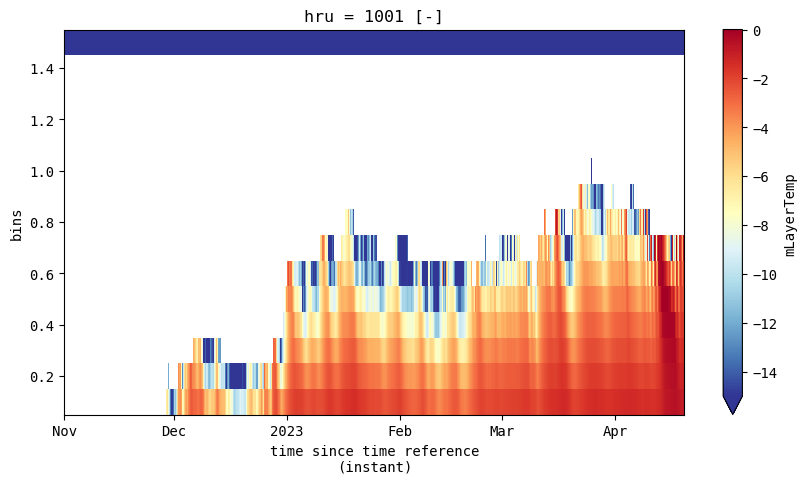

In [174]:
plt.figure(figsize=(10,5))

summa_temps.plot(x='time',y='bins', cmap='RdYlBu_r', vmin=-15, vmax=0)

In [175]:
# Assuming `da1` and `da2` are your DataArrays
summa_temps_aligned, da_aligned = xr.align(summa_temps, da, join='inner')

difference = summa_temps_aligned - da_aligned



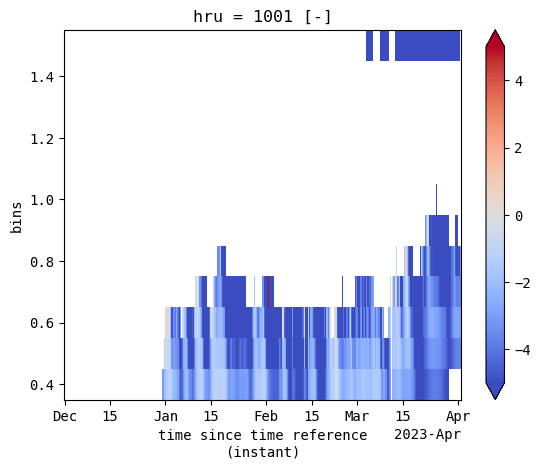

In [176]:
difference.plot(x='time', y='bins', cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

Text(0.05, 0.95, 'blue=SUMMA colder\nred=SUMMA warmer')

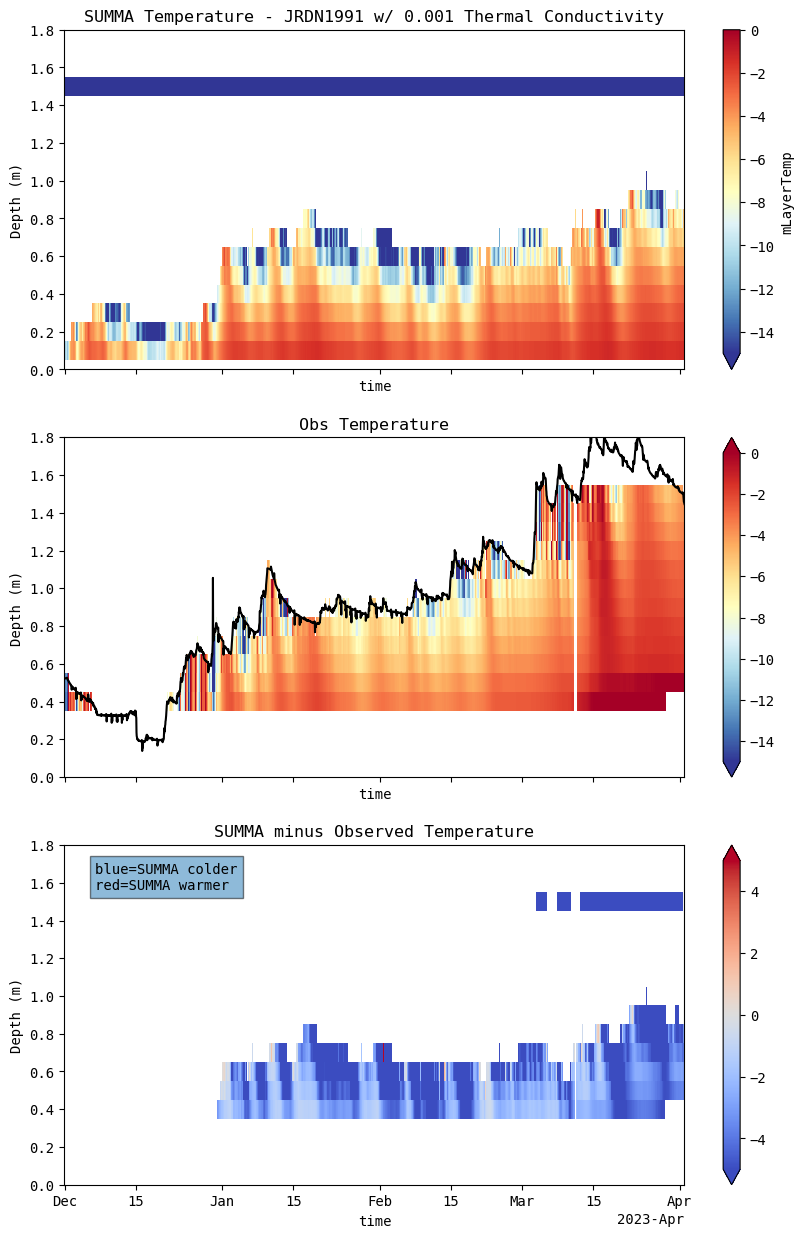

In [177]:
fig, ax = plt.subplots(3,1,figsize=(10, 15), sharex=True)
plt.rcParams['font.family'] = 'monospace'

summa_temps.plot(x='time',y='bins', cmap='RdYlBu_r', vmin=-15, vmax=0, ax=ax[0])
ax[0].set_title('SUMMA Temperature - JRDN1991 w/ 0.001 Thermal Conductivity')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('time')
ax[0].set_ylim(0, 1.8)

ax[1].plot(df.index, df['L4due'], color='black')
da.plot(x='time', y='bins', cmap='RdYlBu_r', vmin=-15, vmax=0, ax=ax[1])
ax[1].set_title('Obs Temperature')
ax[1].set_ylim(0, 1.8)
ax[1].set_ylabel('Depth (m)')


difference.plot(x='time', y='bins', cmap='coolwarm', vmin=-5, vmax=5, ax=ax[2])
ax[2].set_title('SUMMA minus Observed Temperature')
ax[2].set_ylim(0, 1.8)
ax[2].set_xlabel('time')
ax[2].set_ylabel('Depth (m)')
# ax[2].legend()

ax[2].text(0.05, 0.95, 'blue=SUMMA colder\nred=SUMMA warmer', 
           horizontalalignment='left', 
           verticalalignment='top', 
           transform=ax[2].transAxes, 
           bbox=dict(alpha=0.5))


In [178]:
# Assuming `da1` and `da2` are your DataArrays
# da1_aligned, da_aligned = xr.align(da1, da2, join='inner')

# Remove NaN values
da1_aligned = summa_temps_aligned
da2_aligned = da_aligned


In [179]:
# Subset summa_temps between December 1, 2022, and April 1, 2023
summa_temps = summa_temps.loc['2022-12-01':'2023-04-01']

# Subset da between December 1, 2022, and April 1, 2023
da = da.sel(time=slice('2022-12-01', '2023-04-01'))


In [180]:
# Initialize diff_arr with nan
diff_arr = np.full((summa_temps.shape[0], summa_temps.shape[1]), np.nan)

for t in range(len(summa_temps.time.values)):
    # Pull out summa temp array and reverse order
    arr1_s = summa_temps.isel({'time': t}).values[::-1][:-1]
    # Pull out obs temp array and reverse order
    arr2_f = da.isel({'time': t}).values[::-1]

    # Remove nans
    arr1_s = arr1_s[~np.isnan(arr1_s)]
    arr2_f = arr2_f[~np.isnan(arr2_f)]

    # Calculate absolute difference
    min_len = min(len(arr1_s), len(arr2_f))
    # diff = np.abs(arr1_s[:min_len] - arr2_f[:min_len])
    diff = arr1_s[:min_len] - arr2_f[:min_len]


    # Assign diff to the corresponding position in diff_arr
    diff_arr[t, :min_len] = diff

# Mask out differences greater than 20
diff_arr = np.where(diff_arr > 20, np.nan, diff_arr)
diff_arr = np.where(diff_arr < -30, np.nan, diff_arr)

In [183]:
mean_abs_error = np.round(np.nanmean(np.abs(diff_arr)), 3)
mean_error = np.round(np.nanmean(diff_arr), 3)

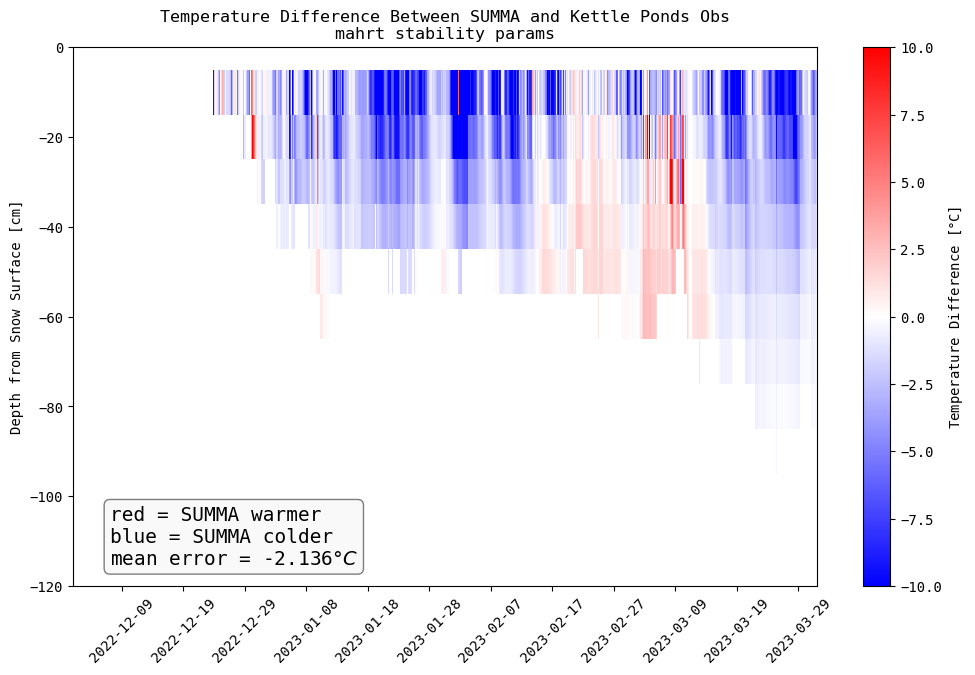

In [190]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import matplotlib.colors as colors
import matplotlib.patches as patches


# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Convert time values to numbers
time_values = mdates.date2num(summa_temps.time.values)

# Create a 2D array of datetime values
time_values_2d = np.tile(time_values, (diff_arr.shape[1], 1)).T

# Create a 2D array of bin indices and multiply by 10
bin_indices = np.tile(np.arange(diff_arr.shape[1]), (diff_arr.shape[0], 1)) * -10

# Create a custom normalization with 0 as the midpoint
norm = colors.TwoSlopeNorm(vmin=-10, vmax=10, vcenter=0)

# Create a pseudocolor plot of the difference array with datetime values on the x-axis
cax = ax.pcolormesh(time_values_2d, bin_indices, diff_arr, shading='auto', 
                    cmap='bwr', norm=norm)

# Add a colorbar
cbar = fig.colorbar(cax)

# Set colorbar ticks from -10 to 10
# cbar.set_ticks(np.arange(-10, 11, 2))

# Set labels
# ax.set_xlabel('Time')
ax.set_ylabel('Depth from Snow Surface [cm]')
ax.set_title('Temperature Difference Between SUMMA and Kettle Ponds Obs\nmahrt stability params')
ax.set_ylim(-120, 0)
cbar.set_label(r'Temperature Difference [$\degree$C]')

# Set x-ticks between Jan 1 and Feb 1, 2023
start_date = datetime(2022, 12, 1)
end_date = datetime(2023, 4, 1)
ax.set_xlim(start_date, end_date)

# Format x-ticks as dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Add a text box
ax.text(0.05, 0.15, f'red = SUMMA warmer\nblue = SUMMA colder\nmean error = {mean_error}'+r'$\degree C$', 
        transform=ax.transAxes, fontsize=14, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5))

# Show the plot
plt.show()